# Lab Report: Part 1. Docker Basics in ML Context

### Student information
- Student name: Bart Peelman
- Student code: 

### *Assignment description*


### *Why is reproducibility crucial in MLOps?*
Reproducibility ensures that a machine learning model behaves exactly the same regardless of where it runs — your laptop, a colleague’s system, a CI pipeline, or a production server. Without reproducibility, you cannot trust your experiments, training runs, or deployments.

### **Think about a scenario where your model works perfectly on your laptop but fails in production. What could be the cause?**
#### ***Scenario***

You train and test a model on your laptop and it works perfectly. When deploying it in production it suddenly fails.

This happens when the environment is not identical between development and production.

### ***What could cause this?***

the most common issues reproducibility prevents:

#### 1. Different library versions

Your laptop: scikit-learn 1.4.0
Production: scikit-learn 1.2.1
→ Even small version differences can change model behavior or break serialization (e.g., joblib).

#### 2. Different Python versions

Your laptop: Python 3.10
Prod: Python 3.8
→ Some packages behave differently or are incompatible.

#### 3. OS-level differences

You train on macOS or Windows, deploy on Linux.
→ Native dependencies (NumPy, TensorFlow, PyTorch) behave differently or fail to compile.

#### 4. Missing or inconsistent system libraries

Example: BLAS, CUDA, glibc versions differ.
→ Leads to slowdowns or crashes.

#### 5. Hidden dependencies that weren’t documented

Your code implicitly relies on something installed only on your laptop.

#### 6. Different hardware

Your model may run with GPU locally but CPU in production, or vice versa.
→ Performance changes dramatically.

#### 7. Data preprocessing inconsistencies

If preprocessing code differs between environments, predictions are no longer reliable.

### ***How does Docker solve this?***
Docker gives you:

- The same environment everywhere
- The same Python and library versions
- The same OS base image
- A fully isolated container per ML model
- Guaranteed consistency between development -> staging -> production

This is why reproducibility is crucial in MLOps and why Docker is the foundation of modern ML deployment.

# Part 1.2 Lab environment setup
### ***Docker Installation Verification***

I installed Docker, Docker Compose, and (for Windows) WSL2. To verify the installation, I ran the following commands:

- docker --version
- docker compose version

### Output:
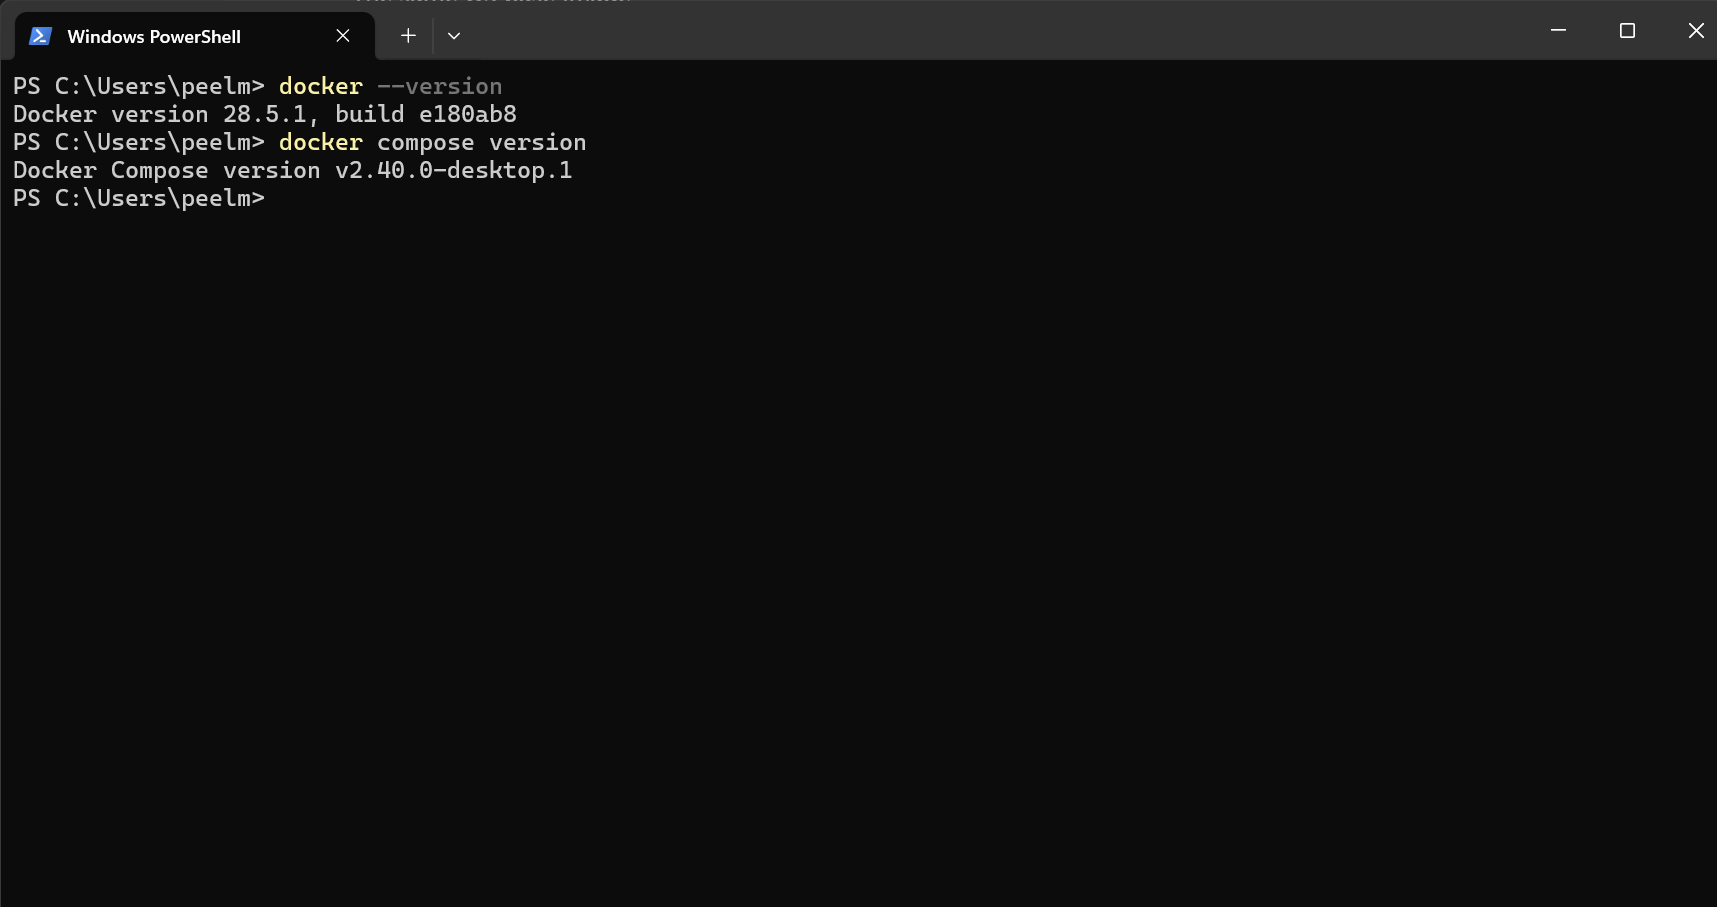



# 1.3 Flask model hosting
## 1.3.1 Setup the environment

### **What does the *python -m venv venv* command do?**
The command python -m venv venv creates a virtual environment for this project.
- python -m venv -> tells Python to run the built-in virtual environment module.
- The first venv refers to the Python module (python -m venv) that handles virtual environment creation.
- The second venv is the name of the folder that will be created to store the virtual environment.

You can rename the second venv (e.g., env, .venv, mlops-env), but the first one cannot change — it is the module name.

### **Make sure your virtual environment is not tracked by Git. How do you do this?**
By adding the virtual environment folder to your .gitignore file.

- add this line to .gitignore: venv/

### **Where are the dependencies installed?**
All dependencies are instelled inside the virtual environment folder I just created:
- venv/Lib/site-packages/

They are not installed globally on my system. This prevents version conflicts and keeps this project isolated.

## 1.3.2 Run the model creation script
I created the model using the command:
- python create_tf_model.py

I also verified the model was created by checking the content of the model_repository\example_model\1\ folder:
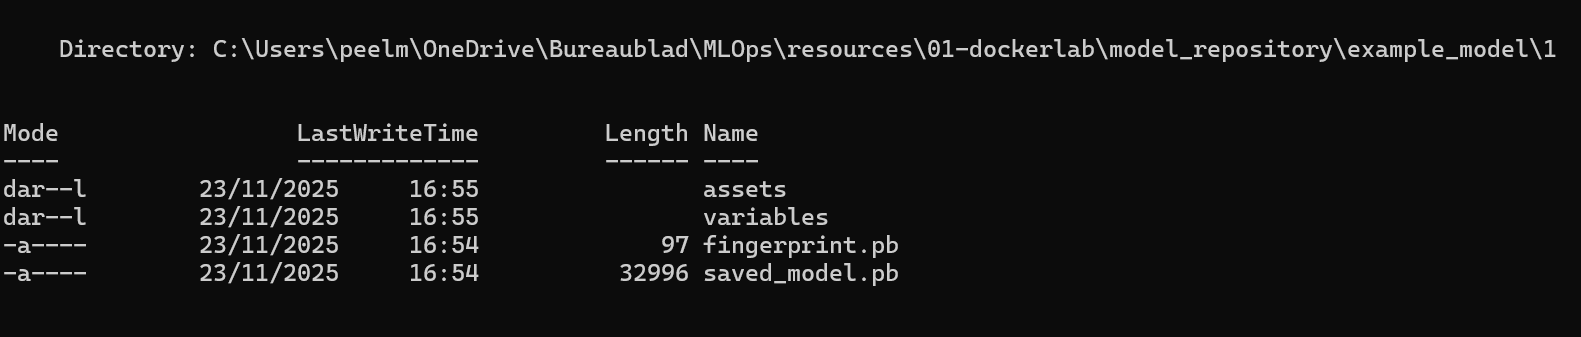

## 1.3.3 Create a Dockerfile
We are starting by creating a Dockerfile in the resourcer\01-dockerlab folder, using all expected requirements.

- Use a Python 3.12 base image (consider using a slim version for smaller size)
- Set a working directory inside the container
- Copy the requirements.txt file first (for better layer caching)
- Install Python dependencies using pip (consider using --no-cache-dir to reduce image size)
- Copy the model
- Copy your application code (app.py)
- Expose port 5000
- Set the command to run your Flask application

### ***Why do we copy requirements.txt before copying the application code? How does this improve Docker layer caching?***
- Docker caches layers. By copying only requirements.txt first and running pip install, future changes to the code (like app.py) won’t force reinstalling all packages.
- This speeds up builds and avoids unnecessary downloads.

### ***Difference between python:3.12 and python:3.12-slim***

- python:3.12 -> Full image, includes many Linux packages, bigger size (~1GB).
- python:3.12-slim -> Minimal image, smaller (~50–70MB), fewer packages, sometimes you need to install OS-level dependencies manually.
- Trade-off: smaller image vs. convenience of pre-installed packages.

## 1.3.4 Build and run the container
### Step 1: Build the Docker image
- Powershell: docker build -t ml-flask-app .

#### *** Explanation of flags: ***
- -t ml-flask-app -> tags the image with a name (ml-flask-app)
  - This is useful for identifying and running images without using the long image ID.

### step 2: Run the container
- Powershell: docker run -p 5000:5000 ml-flask-app

### ***What does the -p 5000:5000 flag do? What would happen if you used -p 8080:5000 instead?***
- Maps host port 5000 → container port 5000.
- If you use -p 8080:5000 → you’d access the Flask app on localhost:8080, while the container still listens on 5000 internally.

### ***What happens if you try to run the container without the -p flag? Can you still access the API?***
- The container runs, but the ports are not exposed to the host, so you cannot access the API from your machine.
- This is only useful for internal container communication.

### Step 3: Inspect images and containers
Powershell: docker images
- Shows all images, the repository, their tags, IMAGE ID, creation date and sizes.

Powershell: docker ps
- Shows running containers: Container ID, Image, Command, Created, Status and their Port mappings.

Powershell: docker ps -a
- Shows all containers, both running and stopped with exit codes.

### Step 4: Test your Flask endpoints
#### ***Health check***
Powershell: Invoke-WebRequest -Url http://localhost:5000/health

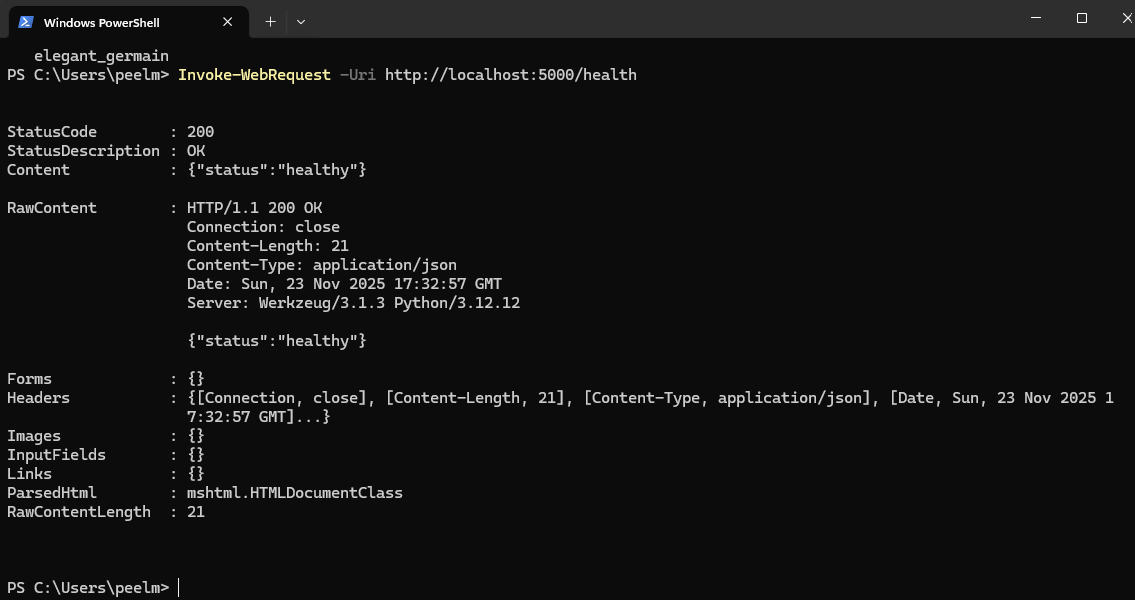

#### ***Predict endpoint***
Powershell: Invoke-WebRequest -Uri "http://localhost:5000/predict" `
- -Method POST `
- -ContentType "application/json" `
- -Body '{"features": [1.2, 3.4, 5.6, 7.8]}'

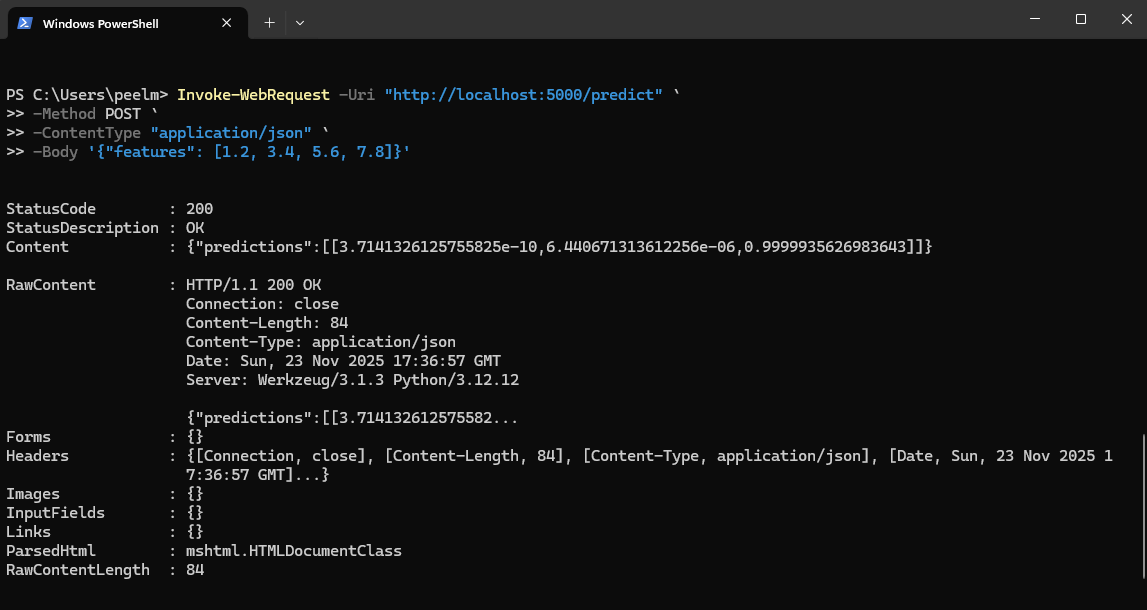



# 1.4 Container registry basics

### Step 1: Tagging the local image
Powershell: docker tag ml-flask-app barttiao/ml-flask-app:0.0.1 (barttiao is momenteel mijn Docker username)
- Creates a tagged version of the image ready for Docker Hub.

### Step 2: Log in to Docker Hub
Powershell: docker login
- Login Succeeded

### Step 3: Push the image to Docker Hub
Powershell: docker push barttiao/ml-flask-app:0.0.1
- Uploads the image to my Docker Hub repository.

### Step 4: Remove the local image (optional)
Powershell: docker image rm peelm/ml-flask-app:0.0.1
- Deletes the local copy, so I can test pulling from Docker Hub.

### Step 5: Pull the image from Docker Hub
Powershell: docker pull barttiao/ml-flask-app:0.0.1
- Downloads the image from Docker Hub to my local machine.

### ***What is the purpose of tagging an image before pushing? What naming conventions should you follow for production images?***
Tagging gives a Docker image a unique, versioned identifier. Without a tag, Docker defaults to the tag latest, which is ambiguous and not safe for deployment.

***Tagging is important because it:***
- Specifies exactly which version of the image you’re pushing or deploying
(e.g., 0.0.1, 1.4.2, 2025-02-11, release-candidate)
- Prevents accidental overwrites of the latest tag.
- Allows version tracking - you can deploy older versions if needed.
- Enables reproducible builds - teams and systems know exactly which version to pull.

***Naming conventions for production images***
Production images should follow predictable, stable, versioned naming, usually based on:
1. Semantic Versioning
   - MAJOR.MINOR.PATCH: e.g. 1.0.0, 1.3.7, 2.1.0, ...
 - Meaning
   - MAJOR -> breaking changes
   - MINOR -> new features
   - PATCH -> bug fixes

2. Never rely on ***latest*** in production

Using latest is discouraged because it:
- can change unexpectedly
- makes deployments non-reproducible
- can break production when a new image is pushed

Always give preference to a specific version tag.

3. Optional environment-specific tags
Useful when deploying multiple stages.
Examples:
- 1.0.0-prod
- 1.0.0-staging
- 1.0.0-dev
This helps keeping environments separate.



# Part 2. Triton Serving

## 2.1 Model repository

### ***Make sure you have the following folder structure in the resources/01-dockerlab folder:*** 

model_repository/ 
└── example_model/
    └── 1/
        └── model.savedmodel/ 
        
### ***Why is the model stored in a folder named 1? What does this number represent?***
Triton uses model versioning.

Each version of a model goes into its own numbered folder:
- example_model/
  - 1/
  - 2/
  - 3/

### ***What does the 1 represent?***
It represents the model version number. Triton loads the highest version number by default.

If you release a new model, you simply add:

- example_model/
  - 2/
      - model.savedmodel/

No need to stop Triton, it can hot-reload.

### ***Why does Triton use versioning?***

Because in production you often need:
- A/B testing of models
- Rolling upgrades
- Safe fallback to older models
- Multiple versions active at once (if enabled)

So the model version number is essential in Triton.

### ***What is the purpose of config.pbtxt? Why is it essential?***
Triton cannot automatically infer everything about the model (especially for TensorFlow SavedModel).

So the config.pbtxt tells Triton:

- The model name
- Which framework the model uses
- The max batch size Triton is allowed to accept
- The input & output names
- Their shapes
- Data types

Triton refuses to load a model if this file is missing or wrong.

***config.pbtxt is the blueprint for Triton.***

Without it, Triton does not know how to feed data into the model or how to interpret the model outputs.

### ***Analyze the config.pbtxt — what does each field mean?***

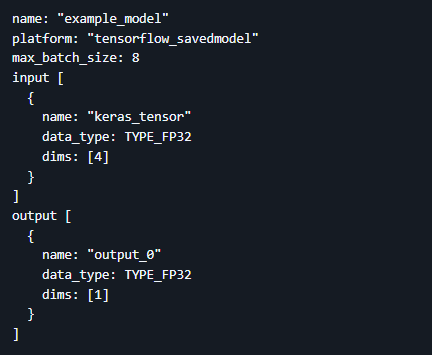

***What does each field represent?***

### `name`
- **Value:** `"example_model"`  
- **Purpose:** The unique identifier for this model in the Triton server.  
- **Notes:** Triton uses this name to refer to the model when handling requests.

### `platform`
- **Value:** `"tensorflow_savedmodel"`  
- **Purpose:** Specifies the framework and format of the model.  
- **Notes:** Determines how Triton loads and executes the model.

### `max_batch_size`
- **Value:** `8`  
- **Purpose:** The maximum number of inference requests Triton can batch together.  
- **Notes:** Helps improve throughput; if set to `0`, batching is disabled.

### `input`
- **Purpose:** Defines the input tensors expected by the model.  
- **Fields:**  
  - `name`: `"keras_tensor"` — Name of the input tensor.  
  - `data_type`: `TYPE_FP32` — Data type of the input (32-bit float).  
  - `dims`: `[4]` — Shape of the input tensor (vector of length 4).

### `output`
- **Purpose:** Defines the output tensors produced by the model.  
- **Fields:**  
  - `name`: `"output_0"` — Name of the output tensor.  
  - `data_type`: `TYPE_FP32` — Data type of the output (32-bit float).  
  - `dims`: `[1]` — Shape of the output tensor (single value).  -> To load the model successfully, I had to update the output dimensions to reflect the real model output (dims: [3]).

## 2.2 Run the Triton Server

#### ***What is the purpose of the volume mapping (-v option)?***
The -v (or --volume) option mounts a directory from your host system into the Docker container.

Why it’s needed:
- Triton needs access to the model files to serve them.
- Without -v, the container would not see my local model files, and I would get errors like “unable to find model”.
- It allows to update models locally without rebuilding the container. Triton can dynamically load them from the mounted folder.

## 2.3 Test Triton endpoints

### Step 1: Check the model status endpoint

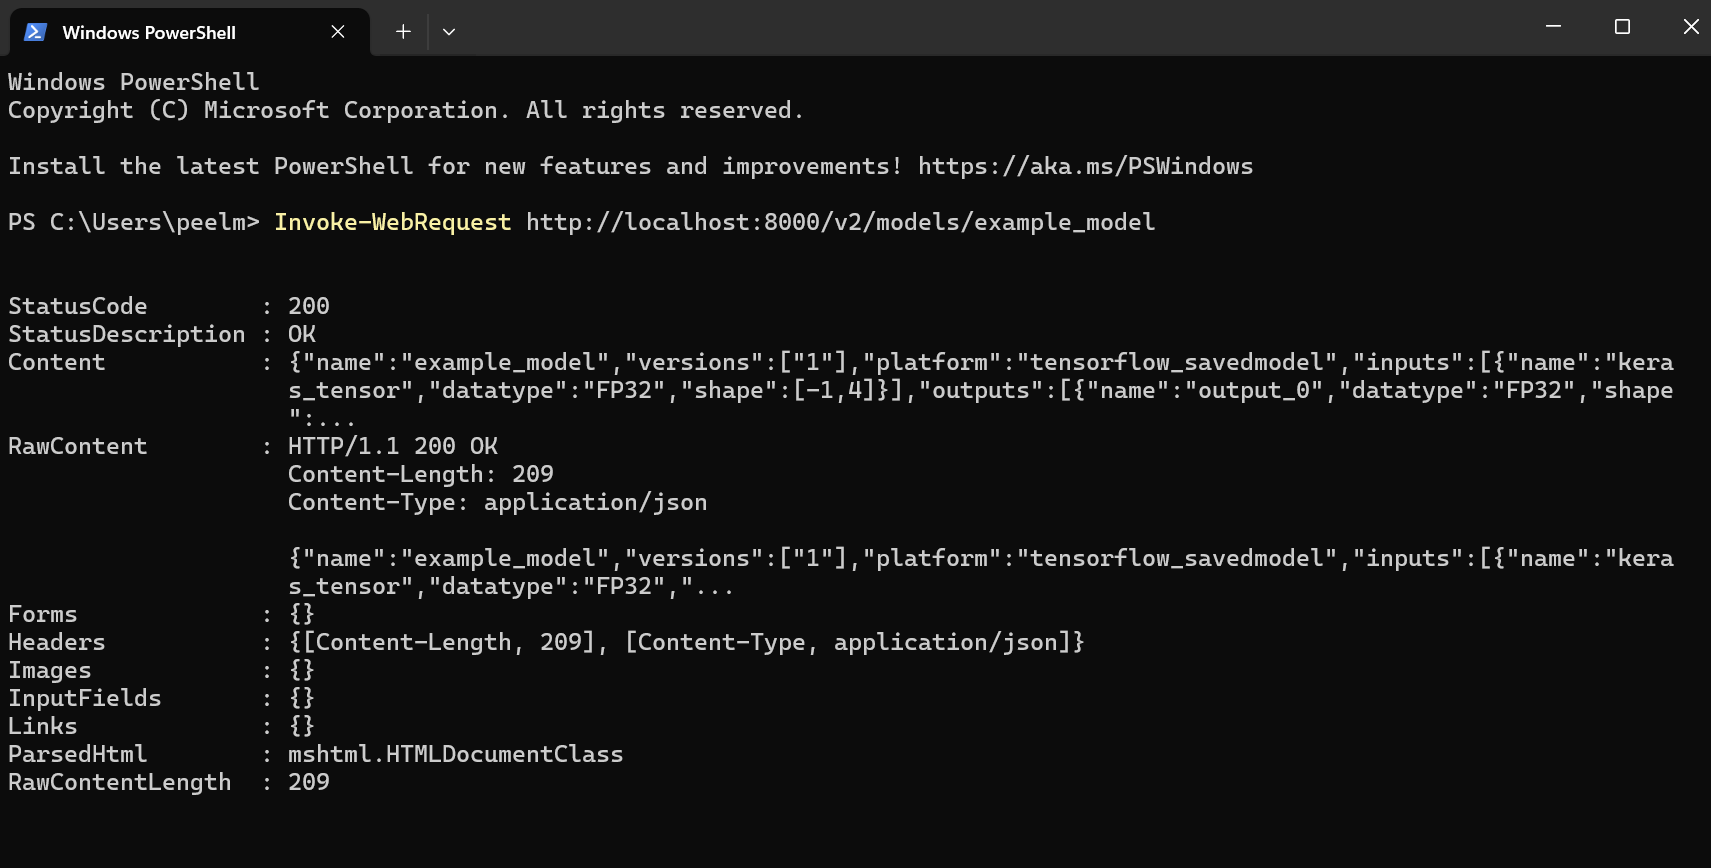

#### ***What information does the model status endpoint provide? How can you use this to debug model loading issues?***
This returns JSON with the model’s information, including:

- Model name and version
- Status (READY, UNAVAILABLE, etc.)
- Backend (e.g., TensorFlow)
- Input and output tensor names, shapes, and types
- Batch size info

***How it helps debugging:***
- If the model fails to load, it will show UNAVAILABLE and error messages.
- You can check whether Triton recognizes the model, the correct version is loaded, and the expected input/output shapes.

### Step 2: Test the inference endpoint

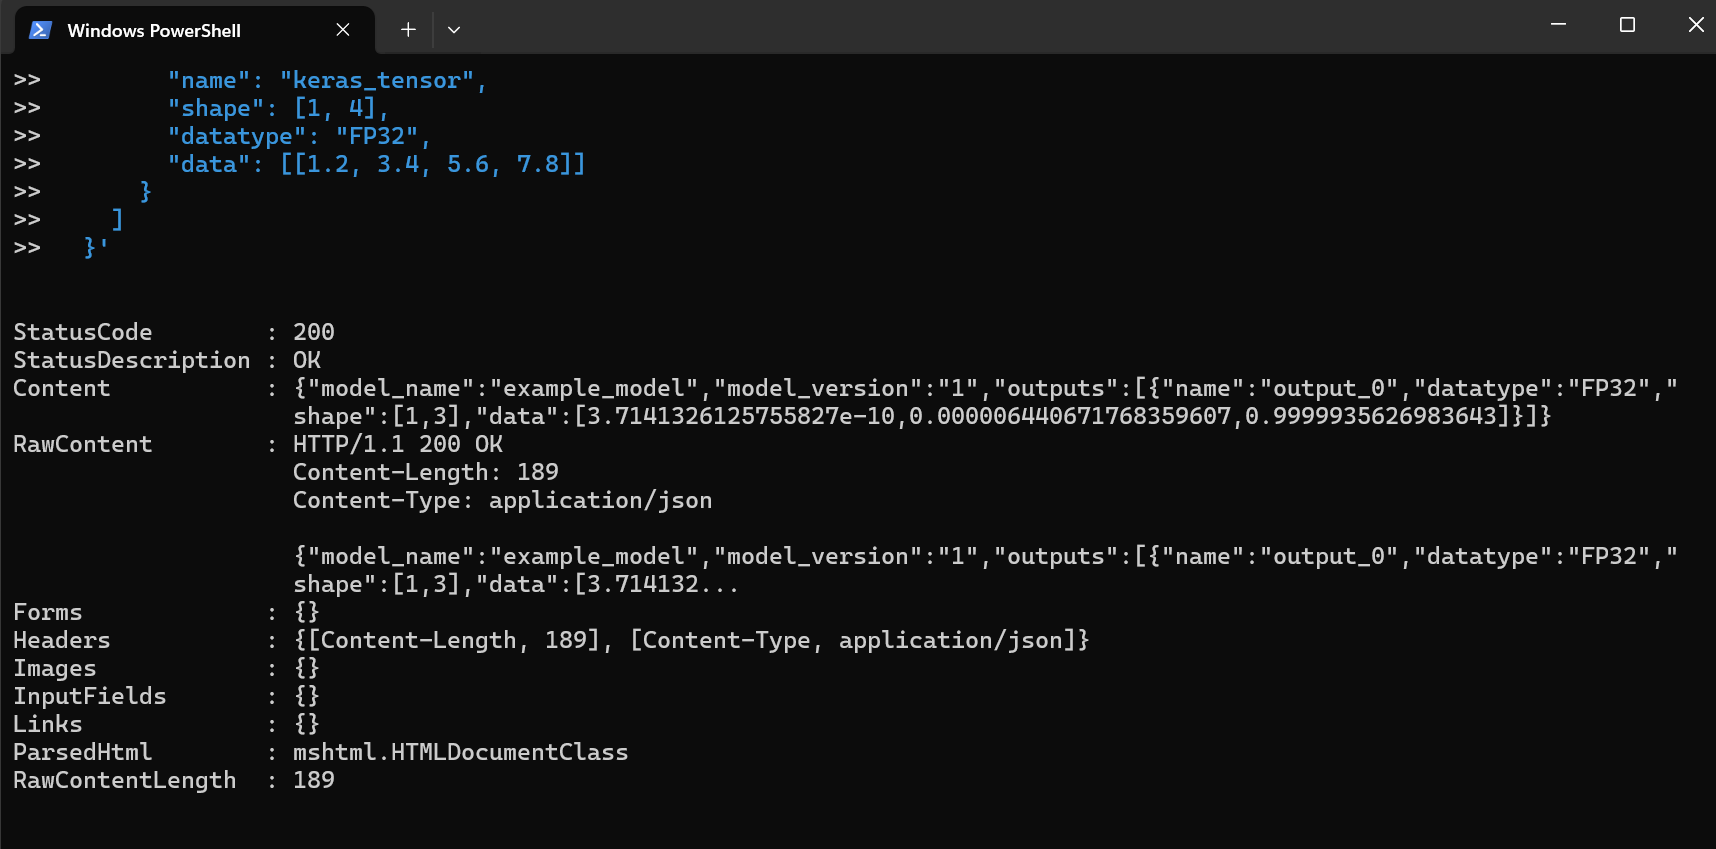

#### ***Test the inference endpoint and analyze the response. What format does the output take? How does it differ from the Flask API response?***

The output is a JSON object:
- Includes outputs array
- Each output has: name, shape, datatype, and data fields

#### ***Triton also supports gRPC What is the difference between HTTP and gRPC for model inference? When would you choose one over the other?***
- Flask API often returns just raw predictions (Python list or NumPy array).

- Triton HTTP API returns a structured JSON with metadata (tensor names, shapes, types), which is more informative for production deployment and automated pipelines.

### Step 3: HTTP vs gRPC

***HTTP:***
- Easy to test with curl or browsers.
- Good for simple REST-based setups.
- Slightly higher latency due to HTTP/1.1 overhead.

***gRPC:***
- Uses binary protocol, more efficient and faster.
- Supports streaming and high-throughput workloads.
- Better for production systems with heavy inference loads or when integrating with other services using protobuf.

***When to choose:***
- HTTP: Quick testing, lightweight apps, simple integration.
- gRPC: Production, batch processing, low-latency/high-throughput inference.

## 2.4 Hosting public models

Here I went with the ResNet50 (ONNX) model because it’s supported in Triton, widely used, and relatively small.

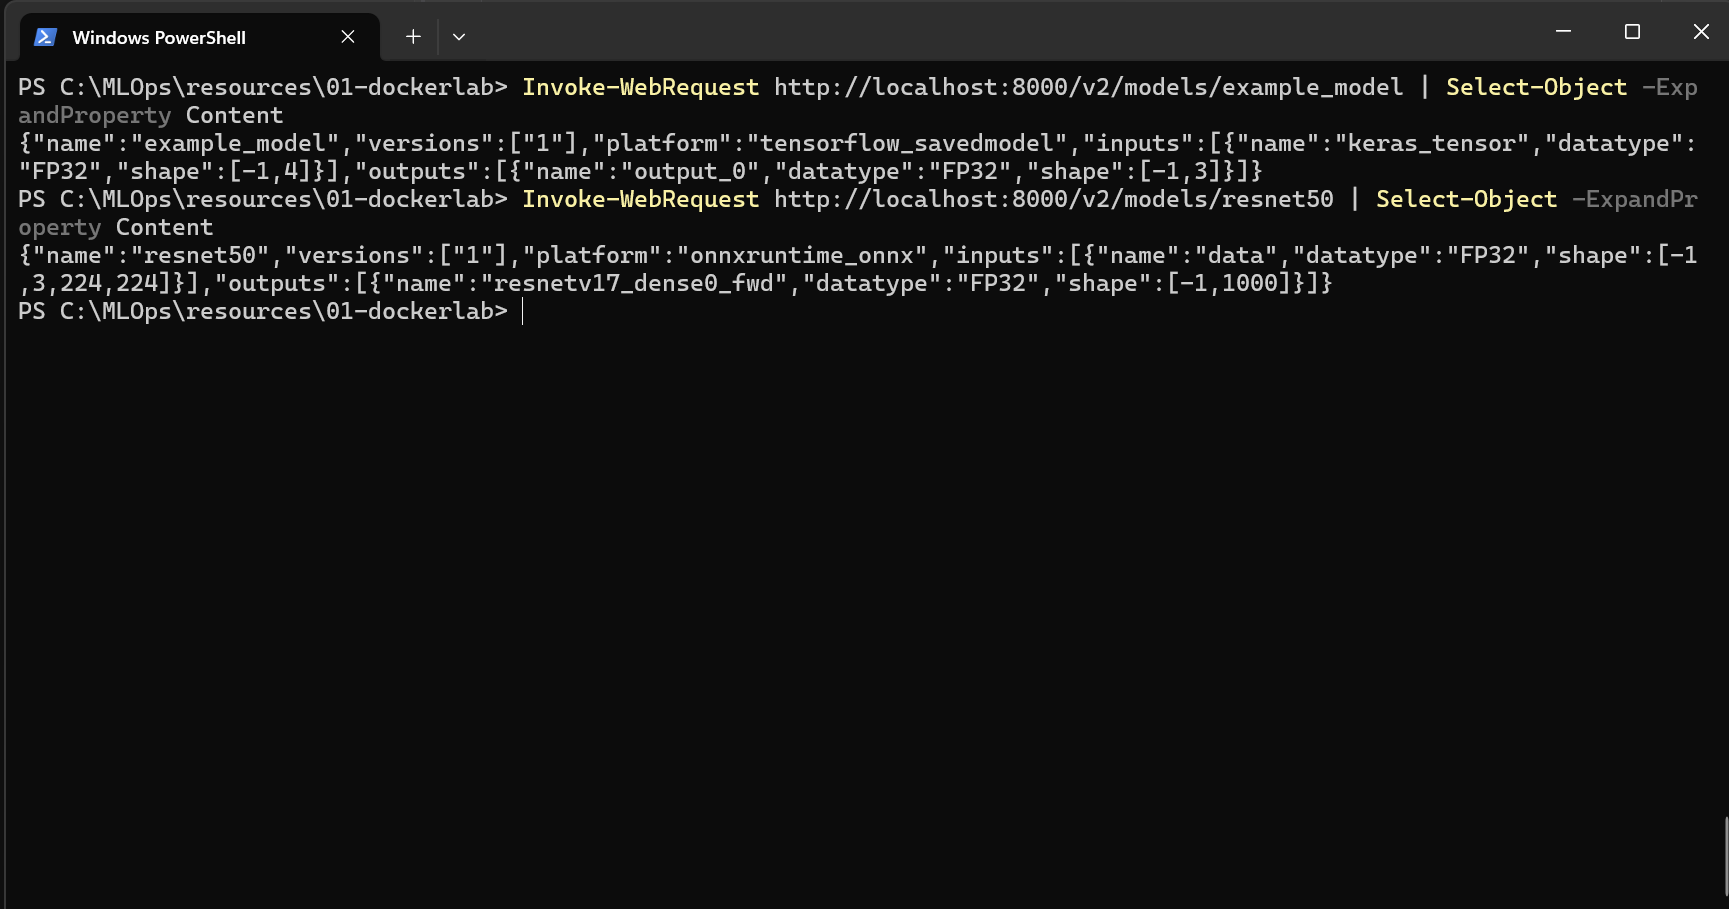

## 2.5 Test the public model

### Step 1: Check the model status
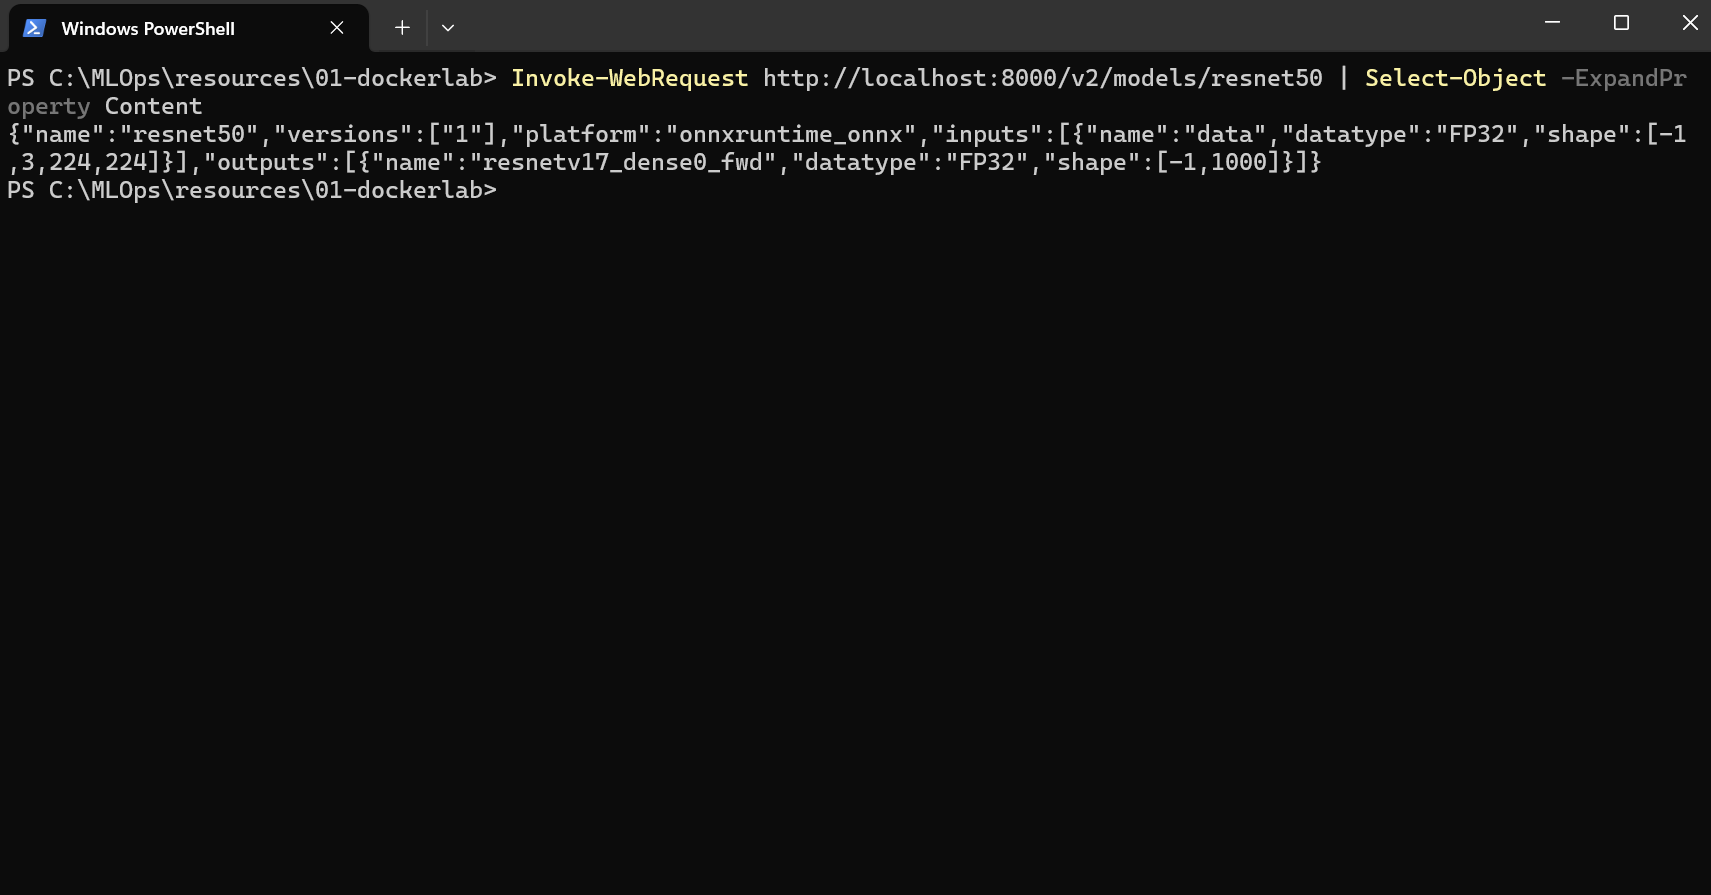

### Step 2: Prepare input data
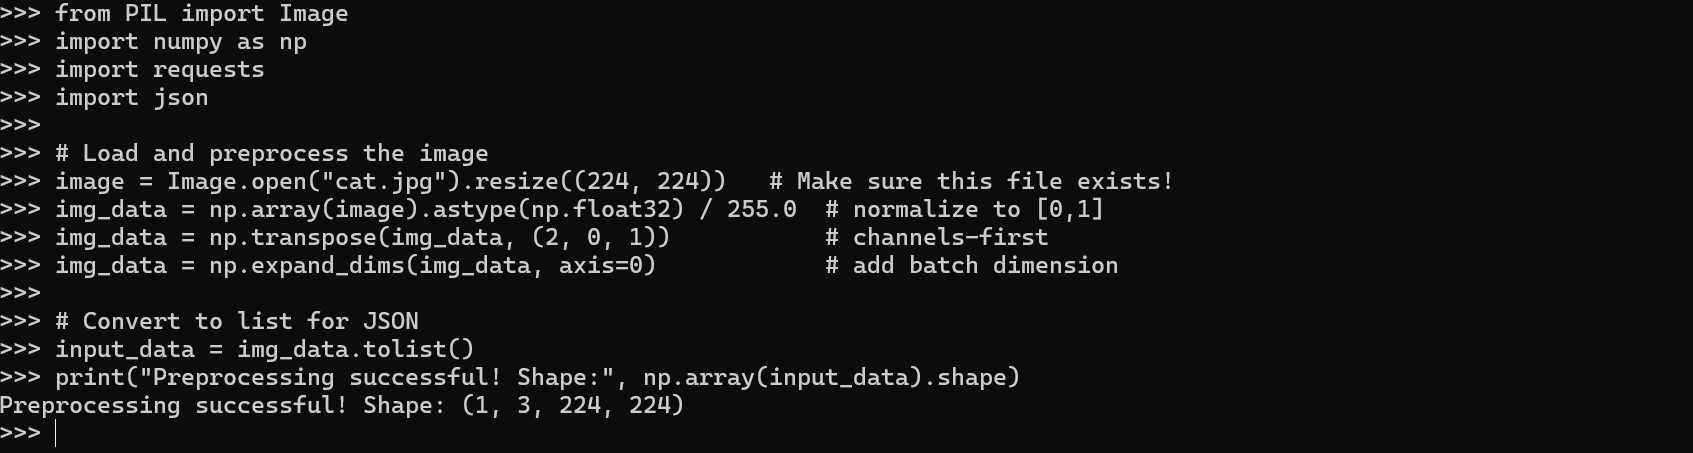

### Step 3: Send inference request
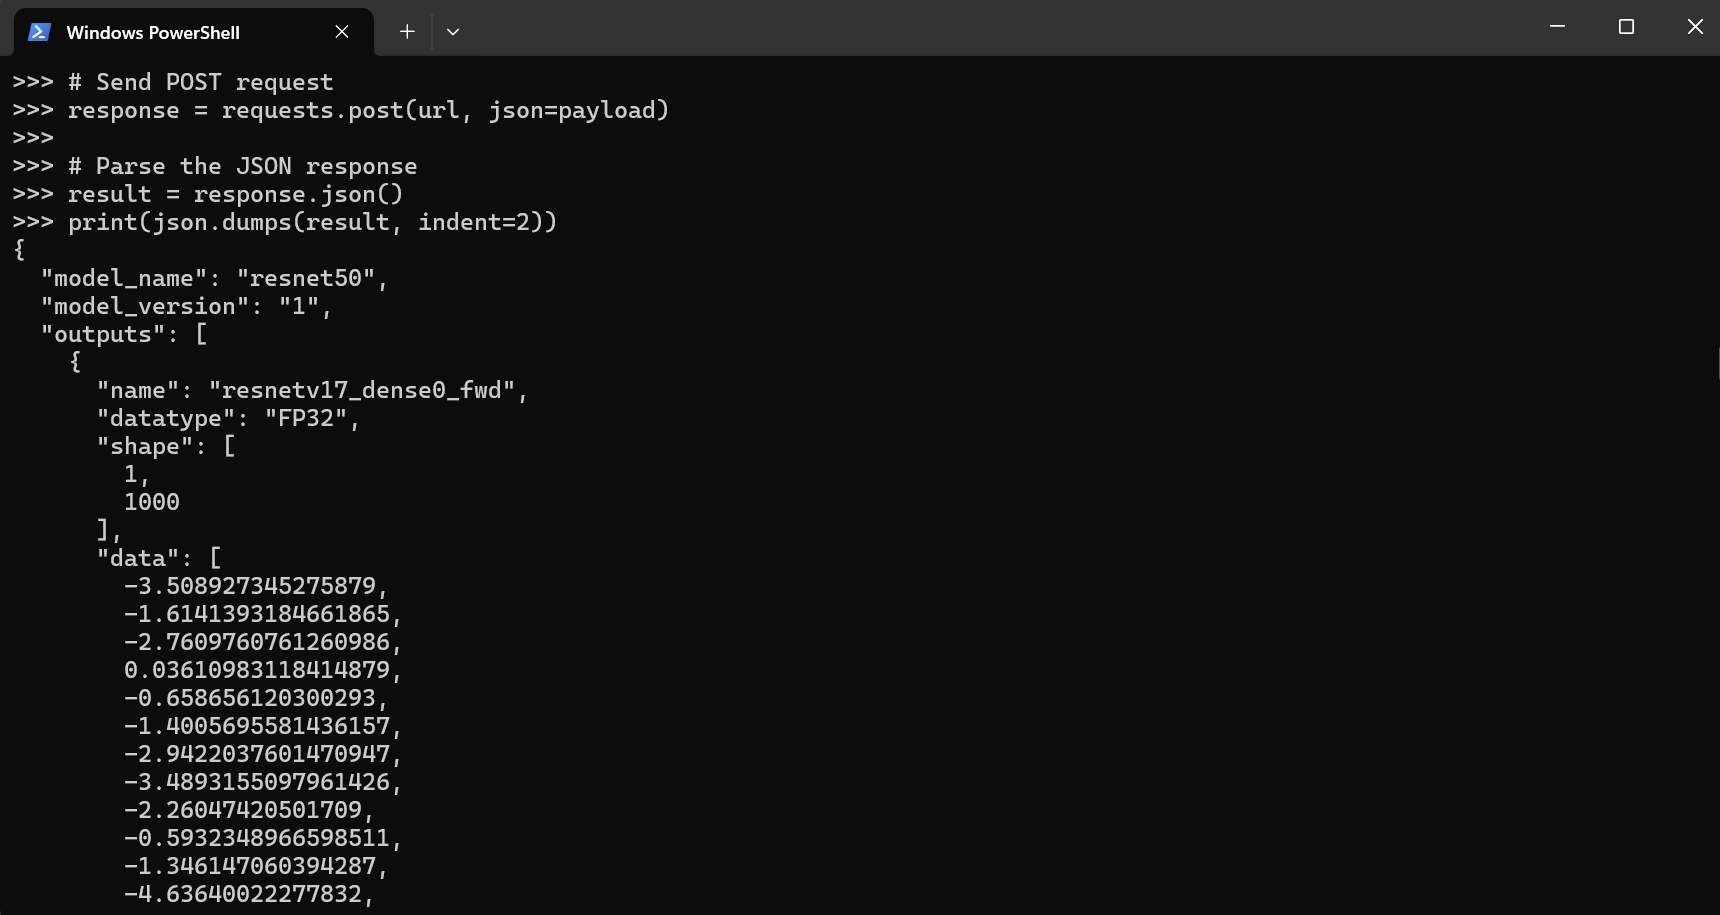

### Step 4: Compare to Flask API
- Triton outputs JSON with metadata (model name, version, shape, datatype) and a data field.
- Flask API often returns just the raw prediction or a simpler JSON.
- Triton is more structured and standardized for serving multiple models.

### Step 5: Notes for myself
- Always match input names, shapes, and data types exactly as Triton reports via the model status endpoint.
- I can wrap this into a small Python helper script to test any new public model added.

## Part 3.0 Docker Compose
### 3.1 Creating a docker-compose.yml
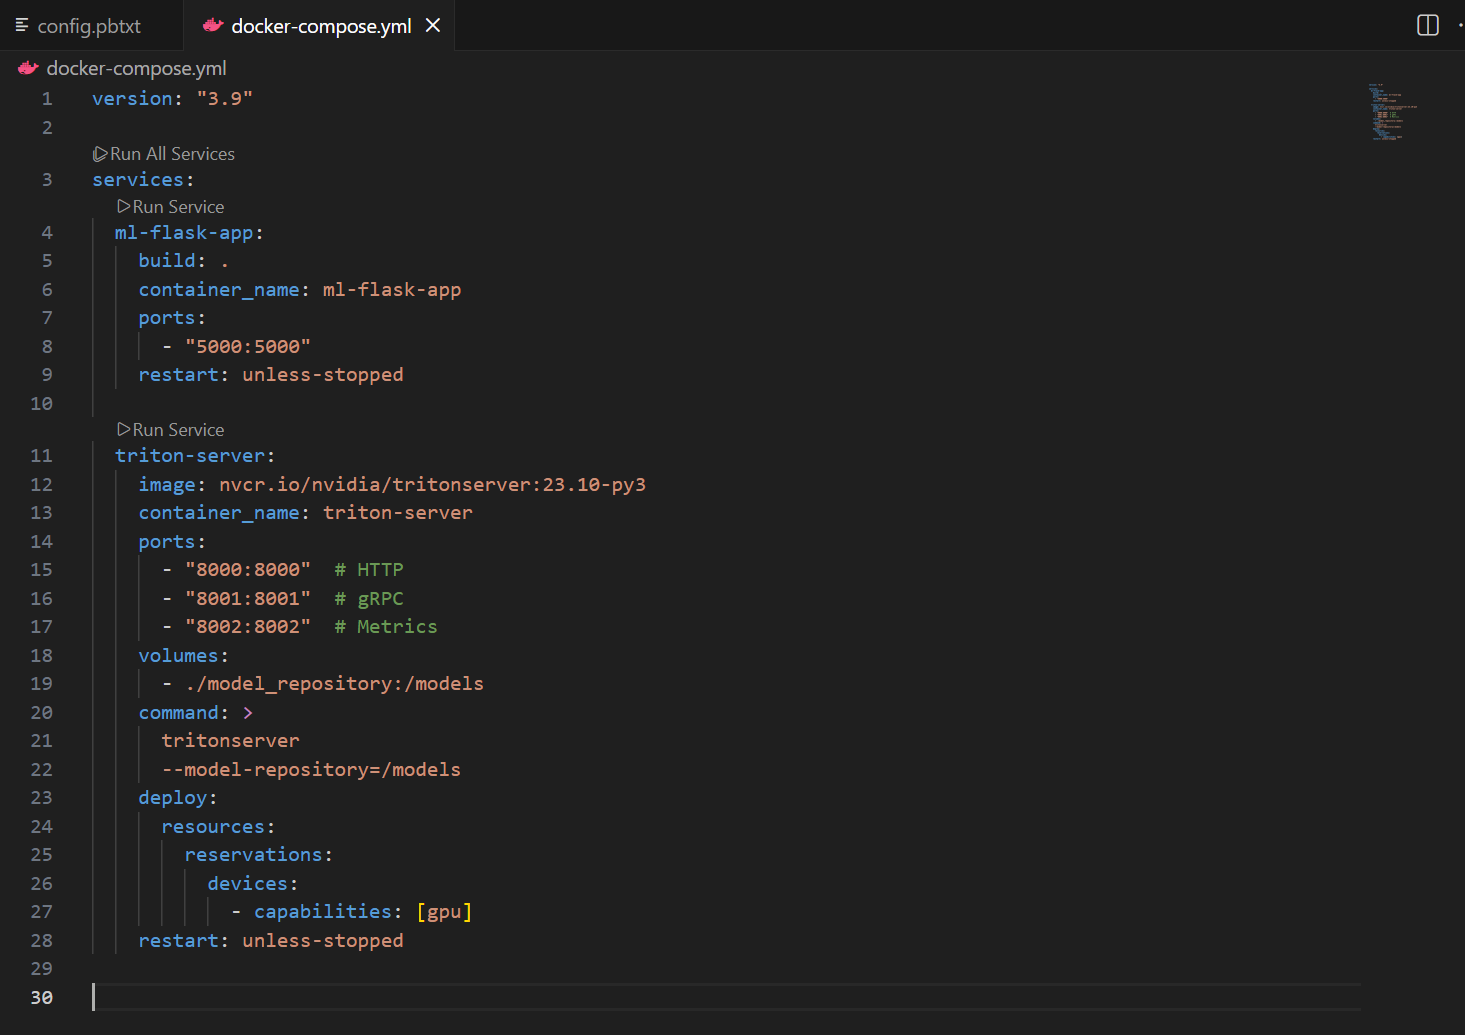

#### ***Start both services in the background:***
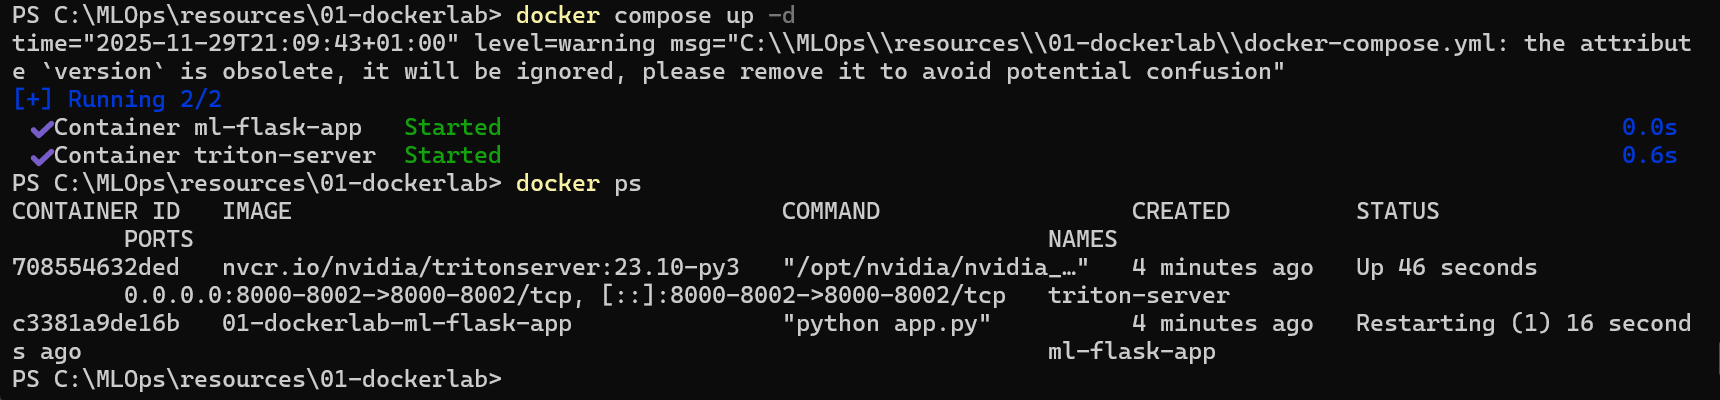

##### ***How can you view the logs of the services?***
View all logs
docker compose logs

### ***Follow logs in real time***
docker compose logs -f

### ***Follow logs for a specific service***
docker compose logs

Logs for a specifice service
- docker compose logs -f ml-flask-app
- docker compose logs -f triton-server


##### ***What does the -d flag do in docker compose up -d? When would you use it vs. not using it?***
The -d flag means detached mode.

- When using it, the containers start in the background and you get back to your terminal immediately.
- Without -d, the containers run in the foreground, showing all logs in your terminal. This is useful for debugging.

##### ***How would you stop the services? What command would you use to stop and remove all containers, networks, and volumes defined in the docker-compose.yml file?***
- To stop the running services: docker compose stop
- To stop and remove all containers, networks, and volumes defined in the docker-compose.yml file: docker compose down --volumes